In [160]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import erfc

In [161]:
def Eb_N0_dB_to_p(Eb_N0_dB):
    # Converter Eb/N0 de dB para valor linear
    Eb_N0 = 10 ** (Eb_N0_dB / 10)
    
    # Calcular a probabilidade de erro p usando a função erfc
    p = 0.5 * erfc(np.sqrt(Eb_N0))
    
    return p

In [162]:
Eb_N0_db = 5
p = Eb_N0_dB_to_p(Eb_N0_db)

In [163]:
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [164]:
# Test the bsc
input = np.array([0, 1, 1, 0])
output = bsc(input, p)
output

array([0, 1, 1, 0], dtype=int32)

In [165]:
# Defining a function as a Hamming coder
def hamming_coder(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity matrix
    G = np.array([[1, 0, 0, 0, 1, 1, 1],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 1, 1, 0],
                  [0, 0, 0, 1, 0, 1, 1]], dtype=int)
    # Encoding the input vector
    output_vector = np.dot(input_vector, G) % 2
    return output_vector

In [166]:
input = np.array([0, 1, 1, 0])
output = hamming_coder(input)
output

array([0, 1, 1, 0, 0, 1, 1], dtype=int32)

In [167]:
# Define a function for the syndrome calculator
def syndrome(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity-check matrix
    H = np.array([[1, 1, 1, 0, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [1, 1, 0, 1, 0, 0, 1]], dtype=int)
    # Decoding the input vector
    output_vector = np.dot(input_vector, H.T) % 2
    return output_vector

In [168]:
# Test the syndrome calculator
input = np.array([1, 0, 1, 1])
coded_input = hamming_coder(input)
coded_input

array([1, 0, 1, 1, 0, 1, 0], dtype=int32)

In [169]:
s = syndrome(coded_input)
s

array([0, 0, 0], dtype=int32)

In [170]:
s_dict = {
    '0': (np.array([0, 0, 0]), np.array([0, 0, 0, 0, 0, 0, 0])),
    '1': (np.array([1, 1, 1]), np.array([1, 0, 0, 0, 0, 0, 0])),
    '2': (np.array([1, 0, 1]), np.array([0, 1, 0, 0, 0, 0, 0])),
    '3': (np.array([1, 1, 0]), np.array([0, 0, 1, 0, 0, 0, 0])),
    '4': (np.array([0, 1, 1]), np.array([0, 0, 0, 1, 0, 0, 0])),
    '5': (np.array([1, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0])),
    '6': (np.array([0, 1, 0]), np.array([0, 0, 0, 0, 0, 1, 0])),
    '7': (np.array([0, 0, 1]), np.array([0, 0, 0, 0, 0, 0, 1]))
}

In [171]:
# Calculating the e_prime from syndrome
def e_prime_calc(s: np.ndarray) -> np.ndarray:
    for s_index in s_dict.items():
        if np.array_equal(s_index[1][0], s):
            return s_index[1][1]

In [172]:
test = np.array([0, 0, 1, 0, 0, 0, 0])
s = syndrome(test)
s

array([1, 1, 0], dtype=int32)

In [173]:
e_prime = e_prime_calc(s)
e_prime

array([0, 0, 1, 0, 0, 0, 0])

In [174]:
# Calculating the e_prime from syndrome
def e_prime_calc(s: np.ndarray) -> np.ndarray:
    for s_index in s_dict.items():
        if np.array_equal(s_index[1][0], s):
            return s_index[1][1]

In [175]:
# Defining the Hamming decoder function with 1-bit correction
def hamming_decoder(input_vector: np.ndarray) -> np.ndarray:
    s = syndrome(input_vector)
    e_prime = e_prime_calc(s)
    decoded = (input_vector + e_prime) % 2
    return decoded[:4]

In [176]:
test = np.array([0, 1, 1, 0, 0, 1, 1])
output_test = hamming_decoder(test)
output_test

array([0, 1, 1, 0], dtype=int32)

In [177]:
def bsc_pb_est(p_values):
    sample_size = 1_000_000
    k = 1
    l = int(sample_size / k)
    
    # Check if p_values is a single float value or an array
    if isinstance(p_values, float) or isinstance(p_values, int):
        p_values = np.array([p_values])
    
    error_probabilities = []

    for p in p_values:
        error_count = 0
        for _ in range(l):
            input_vector = np.random.randint(0, 2, k)
            output_vector = bsc(input_vector, p)
            if not np.array_equal(input_vector, output_vector):
                error_count += 1
        error_probabilities.append((1 / l) * error_count)

    return np.array(error_probabilities)

In [178]:
bsc_pb_est(0.05)

array([0.05039])

In [180]:
def hamming_pb_est(p_values):
    sample_size = 2_000_000
    k = 4
    l = int(sample_size / k)
    
    # Check if p_values is a single float value or an array
    if isinstance(p_values, float) or isinstance(p_values, int):
        p_values = np.array([p_values])
    
    error_probabilities = []

    for p in p_values:
        error_count = 0
        for _ in range(l):
            input_vector = np.random.randint(0, 2, k)
            input_decoded = hamming_coder(input_vector)
            transmitted_vector = bsc(input_decoded, p)
            decoded_vector = hamming_decoder(transmitted_vector)
            if not np.array_equal(input_vector, decoded_vector):
                error_count += 1
        error_probabilities.append((1 / l) * error_count)

    return np.array(error_probabilities)

In [181]:
hamming_pb_est(0.05)

array([0.044404])

In [182]:
Eb_N0_dB_range = np.arange(0, 5.5, 0.5)
p_values = Eb_N0_dB_to_p(Eb_N0_dB_range)
p_values

array([0.0786496 , 0.0670652 , 0.05628195, 0.04640128, 0.03750613,
       0.02965529, 0.02287841, 0.01717254, 0.01250082, 0.00879381,
       0.00595387])

In [183]:
ber_results = hamming_pb_est(p_values)
ber_results

array([0.099992, 0.076082, 0.054708, 0.038904, 0.025822, 0.016632,
       0.010568, 0.00581 , 0.0032  , 0.001622, 0.00075 ])

In [184]:
def plotar_ber(Eb_N0_dB_range, ber_results):
    plt.figure(figsize=(10, 6))
    plt.plot(Eb_N0_dB_range, ber_results, marker='o', linestyle='-', color='b')
    plt.yscale('log')
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taxa de Erro de Bit (BER)')
    plt.ylim([1e-4, 1])
    plt.title('Desempenho Hamming')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

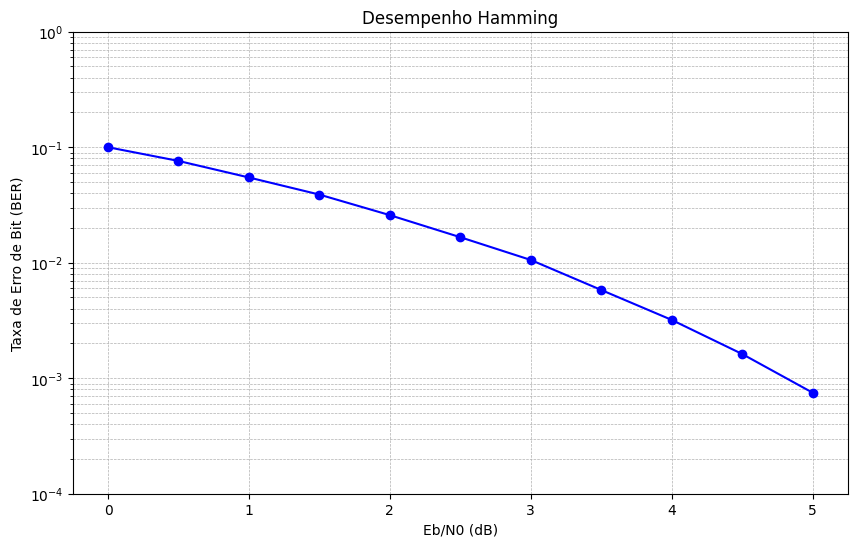

In [185]:
# Plotar o gráfico
plotar_ber(Eb_N0_dB_range, ber_results)

In [185]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: None dB
